# Fase 1 Replicación y Veerificación del Preprocesamiento del Artículo Original.  

1. Carga y Extracción de Datos. :white_check_mark:
2. Redimensionamiento de Imágenes. :white_check_mark:
3. Normalización de Píxeles
4. División del Dataset

## Bibliotecas
Esta celda importa todas las librerías necesarias para el análisis de datos, manipulación de imágenes, visualización y construcción de modelos de aprendizaje automático. Incluye pandas para manejo de datos, matplotlib y seaborn para gráficos, h5py para leer archivos .mat, cv2 (OpenCV) para procesamiento de imágenes, numpy para operaciones numéricas, y tensorflow/keras para redes neuronales.

In [1]:
import pandas as pd
import sklearn
import sys
from os import listdir
import matplotlib as mpl
import os
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
from tensorflow import keras as K
import pennylane as qml
from timeit import default_timer as timer
from datetime import timedelta
import seaborn as sns
from datetime import datetime, timedelta
import random
from tqdm.notebook import trange


Aquí se carga un único archivo de ejemplo (1.mat) del dataset. El propósito es inspeccionar la estructura interna de estos archivos .mat y entender qué tipo de información contienen: la etiqueta del tumor, el ID
del paciente, la imagen en sí, el borde del tumor y la máscara del tumor. Se imprimen las formas y algunos valores para verificar la carga correcta de los datos.


In [2]:
arch = "../DataSet/Tumores/1.mat"
data = h5py.File(arch, 'r')
label = data['cjdata']['label'][0][0]
pid = data['cjdata']['PID'][0]
imagen = data['cjdata']['image']
borde_tumor = data['cjdata']['tumorBorder'][0]
mascara_tumor = data['cjdata']['tumorMask']

print("Label:", label)
print("PID:", pid)
print("Forma de imagen:", imagen.shape)
print("Borde del tumor:", borde_tumor)
print("Mascara del tumor:", mascara_tumor.shape)

Label: 1.0
PID: [49]
Forma de imagen: (512, 512)
Borde del tumor: [267.61524501 231.37568058 277.83666062 248.10163339 289.91651543
 250.8892922  305.71324864 253.676951   318.72232305 249.9600726
 321.50998185 237.88021779 354.96188748 234.16333938 367.97096189
 227.65880218 380.9800363  210.93284936 372.61705989 195.13611615
 363.32486388 177.48094374 350.31578947 176.55172414 336.37749546
 183.98548094 317.79310345 196.06533575 305.71324864 207.21597096
 295.49183303 217.43738657 288.98729583 222.08348457 273.19056261
 223.94192377 268.54446461 228.58802178]
Mascara del tumor: (512, 512)


## Informacion del Dataset
Esta sección se encarga de recorrer todos los archivos .mat en el dataset para extraer las etiquetas de los tumores. Luego, cuenta cuántas imágenes hay de cada tipo de tumor (Meningioma, Glioma, Adenoma hipofisario) y muestra esta distribución tanto en texto como en un gráfico de barras utilizando seaborn y matplotlib. Esto proporciona una visión general de la composición del dataset.

Numero de etiquetas por tipo de tumor:
Meningioma              708
Glioma                 1426
Adenoma hipofisario     930
Name: count, dtype: int64


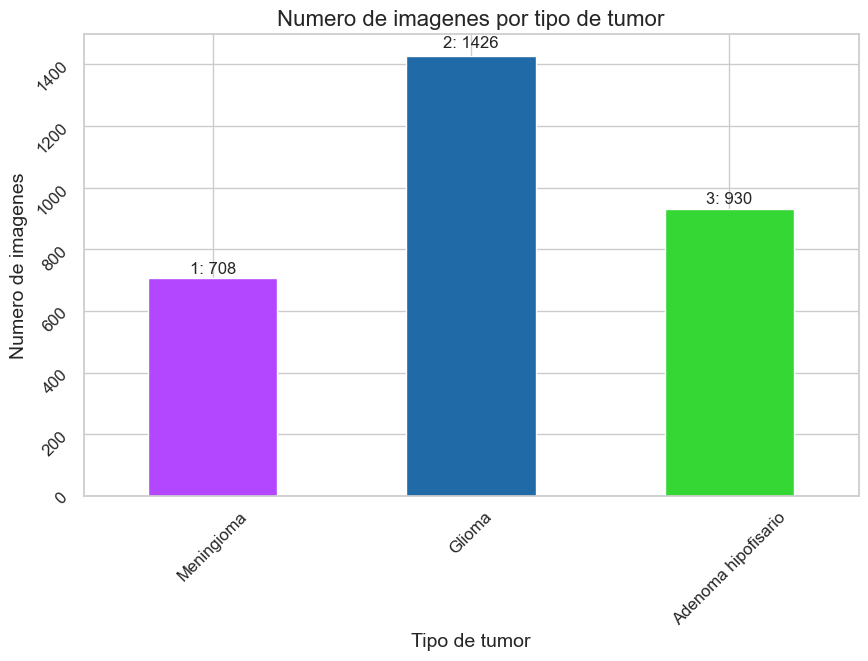

In [3]:
# Cargando las etiquetas de los archivos
folder = "../DataSet/Tumores/"
lista = sorted(os.listdir(folder))
etiquetas = [np.array(h5py.File(f"{folder}{archivo}", 'r').get("cjdata/label")[0][0]) for archivo in lista ]
etiquetas = pd.Series(etiquetas)

# Contando el número de etiquetas por tipo de tumor
# El dataset contiene 3 tipos de tumores, cuyas etiquetas son 1 para Meningioma, 2 para Glioma, 3 para Adenoma hipofisario.
nombres = ["Meningioma", "Glioma", "Adenoma hipofisario"]
# Ordenamos el vector de los nombres y las etiquetas para que coincidan con el orden de los tumores en el dataset
numEtiquetas = etiquetas.value_counts().sort_index()
numEtiquetas.index = nombres

print("Numero de etiquetas por tipo de tumor:")
print(numEtiquetas)

sns.set_theme(style="whitegrid")

ax = numEtiquetas.plot(kind='bar', figsize=(10, 6), color=["#B247FF", "#1F6AA7", "#34D734"])

ax.set_title("Numero de imagenes por tipo de tumor", fontsize=16)
ax.set_xlabel("Tipo de tumor", fontsize=14)
ax.set_ylabel("Numero de imagenes", fontsize=14)

ax.tick_params(labelsize=12, rotation=45)

for i, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{i+1}: {height}", (x + width/2, y + height*1.02), ha='center', fontsize=12)

plt.show()


## Ejemplo de una imagen del dataset    
En esta celda, se itera a través de los archivos del dataset para cargar las imágenes y sus máscaras. Se realiza un paso crucial: las imágenes originales (que son de un solo canal, escala de grises) se "apilan" 4 veces para crear una representación de 4 canales. Esto es común para adaptar las imágenes a modelos de redes neuronales que esperan múltiples canales de entrada. Finalmente, se imprimen las dimensiones de las etiquetas, imágenes (ya con 4 canales) y máscaras recolectadas.

In [4]:
etiquetas = []
imagenes = []
mascaras = []

for archivo in lista:
    #leemos los datos de los archivos .mat
    data = h5py.File(f"{folder}{archivo}", 'r')
    #obtenemos las etiquetas 
    etiqueta = np.array(data.get("cjdata/label"))[0][0]
    #Si la etiqueta no esta en la lista de etiquetas
    if etiqueta not in etiquetas:
        etiquetas.append(etiqueta)

        #obtenemos la imagen 
        imagen = np.stack((np.array(data.get('cjdata/image')),)*4, axis=-1)
        imagenes.append(imagen)
        #obtenemos la mascara del tumor
        mascara = np.array(data.get('cjdata/tumorMask'))
        mascaras.append(mascara)

# Convertimos las listas a arrays de numpy
etiquetas = np.asarray(etiquetas)
imagenes = np.asarray(imagenes)
mascaras = np.asarray(mascaras)

# Mostramos la forma de los arrays
print("Forma de etiquetas:", etiquetas.shape) # 3 tumores
print("Forma de imagenes:", imagenes.shape) # (número de imágenes (una por tumor) 3 , altura, anchura, canales)
print("Forma de mascaras:", mascaras.shape) # (número de imágenes, altura, anchura)



Forma de etiquetas: (3,)
Forma de imagenes: (3, 512, 512, 4)
Forma de mascaras: (3, 512, 512)


Esta es la parte donde se prepara y muestra un ejemplo visual de las imágenes. Primero, las máscaras se convierten a un formato categórico. Luego, las imágenes se normalizan (escalando sus valores de píxeles). Se utiliza la máscara del tumor para "resaltar" el tumor en la imagen, creando una representación visual donde el tumor es visible sobre un fondo. Finalmente, se muestran tres imágenes de tumores ejemplares (una por cada tipo de tumor) con sus respectivos títulos, permitiendo una inspección visual de los datos procesados.

Forma de mascaras categóricas: (3, 512, 512, 4)
Forma de imagen normalizada: (3, 512, 512)
Forma de imagenes del tumor: (3, 512, 512, 3)


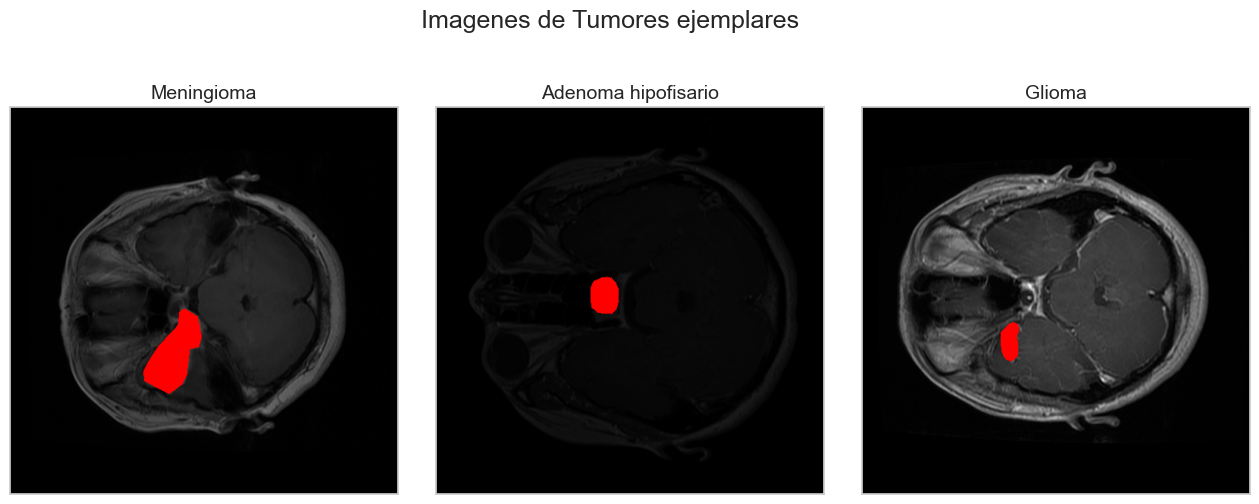

In [5]:
b = K.utils.to_categorical(mascaras, num_classes=4).astype(np.uint8)  # Convertimos las máscaras a formato categórico
print("Forma de mascaras categóricas:", b.shape) # (número de imágenes, altura, anchura, número de clases)

tumor = np.zeros_like(imagenes[:,:,:,1:])  # Creamos un array para almacenar la información del tumor

# Normalizamos las imágenes
imagenNormalizada = cv2.normalize(imagenes[:, :, :, 0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F ).astype(np.uint8)  # Convertimos a uint8 para que sea compatible con OpenCV

# Mostramos un ejemplo de una imagen del dataset
# y checamos que normalizamos correctamente
print("Forma de imagen normalizada:", imagenNormalizada.shape)  # (número de imágenes, altura, anchura)

tumor[:, :, :, 0] = imagenNormalizada * (b[:, :, :, 0])  # Aplicamos la máscara para obtener la imagen del tumor
tumor[:, :, :, 1] = imagenNormalizada * (b[:, :, :, 0])  # Aplicamos la máscara para obtener la imagen del tumor
tumor[:, :, :, 2] = imagenNormalizada * (b[:, :, :, 0])  # Aplicamos la máscara para obtener la imagen del tumor

tumor += b[:,:,:, 1:] * 255  # Añadimos el fondo blanco para las áreas no tumorales

# Mostramos las dimensiones de las imágenes del tumor
print("Forma de imagenes del tumor:", tumor.shape) 

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

for i in range(3):
    ax[i].imshow(tumor[i], cmap='gray')

    ax[i].set_title(nombres[int(etiquetas[i]-1)], fontsize=14)

    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('Imagenes de Tumores ejemplares', fontsize=18)

fig.subplots_adjust(wspace=0.1)

# Tareita

- Dividir los conjuntos de datos para cada quién. 
- Tener una función que haga la partición y división con una semilla.
- Función para cargar la info.
- Tener listo un dataset aparte donde las imágenes ya esten preprocesadas.
  - Normalizadas, estudiadas etc.
  - Listo para una CNN.
- Tener una Red Neuronal Clásica que clasifique estas imágenes: Softmax.


Para **Viernes 22 de Agosto** 

### Dividir 1/3 del DataSet

In [23]:
from pathlib import Path

# Ruta del DataSet
dir = "../DataSet/Tumores/"

# Crea el DataFrame con las imágenes .mat usando h5py y filtrando a los canales de imagen y etiqueta
rows = []
for path in Path(dir).glob("*.mat"):
    with h5py.File(path, "r") as f:
        cj = f["cjdata"]
        imagen = cj["image"][()]                     # Obtiene la imagen
        etiqueta = int(np.squeeze(cj["label"][()]))  # Obtiene la etiqueta y la fuerza a entero

    rows.append({"imagen": imagen, "etiqueta": etiqueta})

df = pd.DataFrame.from_records(rows)

In [ ]:
X = df["imagen"].to_list()
y = df["etiqueta"].to_list()

# Dividir el DataFrame en conjunto de 1/3 del DataSet aleatoriamente y replicable con semilla
LeoDS_train, LeoDS_test, Leolabels_train, Leolabels_test = train_test_split(
    X, y, test_size=1/3, random_state=12, shuffle=True
)
print("Número de imágenes en el conjunto de entrenamiento:", len(LeoDS_train))
print("Número de imágenes en el conjunto de prueba:", len(LeoDS_test))

Número de imágenes en el conjunto de entrenamiento: 2042
Número de imágenes en el conjunto de prueba: 1022


## Proprocesamiento

## Entrenamiento de la NN para clasificacion con FA Softmax